# Diabetes Dataset Classification

LOAD DATA

In [ ]:
import importlib
import functions
importlib.reload(functions)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import torch 
import torch.nn as nn
import torch.optim as optim
from functions import scaled_tensorize_data, datasets_and_loaders, train_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



diabetes_data = pd.read_csv('DATASET\diabetes_binary_health_indicators_BRFSS2015.csv')

Y = diabetes_data["Diabetes_binary"]
X = diabetes_data.drop("Diabetes_binary", axis=1)

# Transform the dataset into numpy arrays
X = X.to_numpy()
Y = Y.to_numpy()



In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42, stratify=Y_train)

print(X_train.shape)

(152208, 21)


In [22]:
pipeline = Pipeline([
        ('median', SimpleImputer()),
        ('scaler', StandardScaler()),
        ('classifier',LogisticRegression())])

pipeline.fit(X_train, Y_train)

print("Accuracy:", pipeline.score(X_test,Y_test ))


Accuracy: 0.8620309050772627


In [25]:
#### Convert in tensor values ####

X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor, X_test_tensor, Y_test_tensor = scaled_tensorize_data(X_train, Y_train, X_val, Y_val, X_test, Y_test)


In [26]:
from torch.utils.data import TensorDataset, DataLoader
import math
import os

#### Create datasets ####
train_ds = TensorDataset(X_train_tensor, Y_train_tensor)
test_ds = TensorDataset(X_test_tensor, Y_test_tensor)

#### Create dataloaders ####
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  pin_memory=True, num_workers=0)
val_loader   = DataLoader(test_ds,   batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Initialize the model ####
input_size = X_train.shape[1]
hidden1_size = 16
output_size = 1

model = functions.initialize_MLP(input_size, hidden1_size, output_size)

model = model.to(device)

##### Define loss function and optimizer ####

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

scheduler_type = 'plateau'  # 'step' or 'cosine' or 'plateau' or None

Training finished.


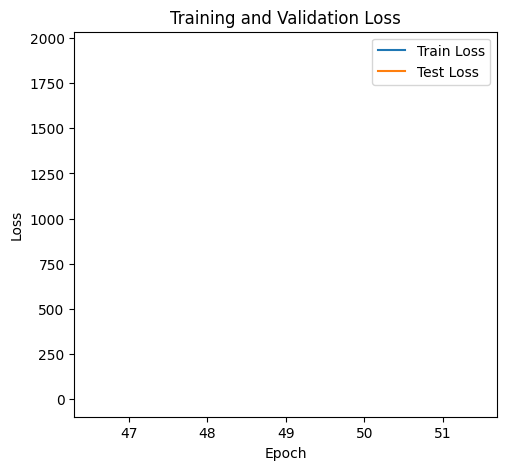

In [ ]:
history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs,
    scheduler_type=scheduler_type,
    print_every_epochs=5
)
# Plot training/validation loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["epoch"], history["train_loss"], label="Train Loss")
plt.plot(history["epoch"], history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Evaluate the model on the test set
functions.evaluate_MLP(model, X_test_tensor, Y_test_tensor)